# Going Deeper #2 : 네이버 영화리뷰 감정분석 문제에 SentencePiece 적용해 보기

문제에서 tokenizer를 KoNLPy에서 제공하는 형태소 분석기를 대신 sentencepiece로 전처리를 해서 풀어본다면 더 성능이 좋아질까요?

    네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기

    학습된 모델로 sp_tokenize() 메소드 구현하기

    구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기

    KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기


평가문항	상세기준

1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?
	코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?

2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?
	SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.

3. SentencePiece의 성능을 다각도로 비교분석하였는가?
	SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.

In [35]:
import pandas as pd
import os

train_path = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/naver_movie/ratings_train.txt'
test_path = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/naver_movie/ratings_test.txt'


train_data = pd.read_csv(train_path, sep='\t')
test_data = pd.read_table(test_path, sep='\t')

In [36]:
train_data.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [37]:
test_data.head(3)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0


In [38]:
len(train_data), len(test_data)

(150000, 50000)

max length: 146
min length: 1


<AxesSubplot:>

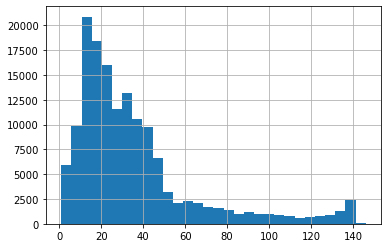

In [39]:
train_data['len_doc'] = train_data['document'].apply(lambda x: len(str(x)))
print(f"max length: {train_data['len_doc'].max()}")
print(f"min length: {train_data['len_doc'].min()}")
train_data['len_doc'].hist(bins=30)

max length: 144
min length: 1


<AxesSubplot:>

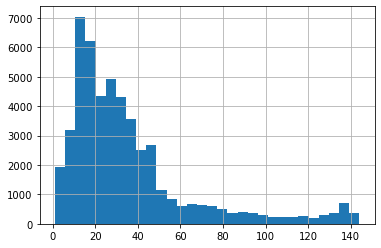

In [40]:
test_data['len_doc'] = test_data['document'].apply(lambda x: len(str(x)))
print(f"max length: {test_data['len_doc'].max()}")
print(f"min length: {test_data['len_doc'].min()}")
test_data['len_doc'].hist(bins=30)

+ 두 데이터의 분포가 유사하다.
  + 두 데이터 모두 오른쪽 꼬리 쪽이 살짝 올라온 것을 보면 1차 전처리가 된 데이터이거나 입력 시스템 상에서 최대 글자 제한이 있는 모양이다.

In [41]:
train_data.len_doc.max()

146

In [42]:
# 길이 1인 문장 확인
def check_sentence_with_length(df, length):
    count = 0
    
    for sen in df['document']:
        if len(str(sen)) == length:
            print(sen)
            count += 1
            if count > 20: return

check_sentence_with_length(train_data, 1)

아
잼
1
4
4
굿
짱
휴
.
1
굿
음
?
?
ㅎ
굿
ㅋ
굿
즐
♥
굳


In [43]:
check_sentence_with_length(train_data, 2)

최고
졸작
대박
버려
망함
굳굳
안습
망작
ㅇㅇ
쵝오
쵝오
최고
굿!
별루
씐나
쓰렉
최고
볼만
허접
최고
비추


In [44]:
check_sentence_with_length(train_data, train_data.len_doc.max())

"스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...독일3사&슈퍼카 홍보 프로그램도 아니구.대중적인 자동차 방송으로 이루어 졌으면 합니다. 보는내내 ""카탈로그 책자""를 ""동영상으로 보여주는 방송"" 같아서 씁쓸하네요.!"
"""니 짓은 생각않고, 웬 복수!""의 교훈이라! 그럼 ""서바이벌 액션""으로 홍보하면 안되지! 초반 45분은 멋지게 열더니.. 억지 반전, 하드고어로 시간끌다가, 허둥지둥 화해로 끝내버리네. 90분 러닝타임에 엔딩자막만 11분 틀어주는 해괴망측한 영화~!"
"2007.02.25_ 벌교의 한 국밥집_ 점심: ""갸는 첫째고, 저 놈은 우리 둘째~"" 재문: ""아줌마! 미안해~ 그냥.. 아줌마! 나 그 남방 잘 어울려ㅠ_ㅠ?"" 대식에게 복수하려던 1주일 전_ 대식의 엄마를 먼저 만났다. 사랑의 꽃남방도..^-^o"


In [45]:
check_sentence_with_length(test_data, 1)

.
굿
헐
d
굳
굿
b
ㅗ
ㄱ
ㄹ
굿
하
?
1
ㄹ
ㅋ
음
꿈
뻑
땡
ㅂ


In [46]:
check_sentence_with_length(test_data, 2)

글쎄
--
대박
조음
별로
토해
최악
최고
^^
졸작
최강
ㅠㅠ
~~
개쩜
최고
지루
별로
맞아
ㅇㅇ
허접
좋음


In [47]:
check_sentence_with_length(test_data, test_data.len_doc.max())

"완전! 재밌더라~ 상투적이라고해도 상관없다~ 재밌었다!~ 김해숙 님의 연기 내공도 좋았고~""미친 년~"" 남발~ㅋ 이민정의 풋풋한 모습도 좋았음...어여~다시 대중에게 돌아와주길!~ 이정진은 말죽거리잔혹사 이후로 좋은 연기 보여줬음~ 정유미도 예쁨~^^"
"평식이가 평점 5 점 줬으면 ,최소한 곱하기 2 배 평점 10 점 줘도 되는 영화다(웃음)평식이는 크리스토퍼 놀란의다크나이트에도""동전 던지기는 너무 진부래""이러면서 평점 7점 주는 인간.평식이가 평론가면,나도 영화감독이다.스마트폰으로 촬영할줄은 아니까"
"차라리 막장이면 욕이나 하지 이건 개콘의 시청률의 제왕이 만드는 드라마보다 못해 작가랑 피디가 ""기왕 망한거 끝까지 가보자""는 마음으로 제대로 낄낄대며 장난친듯. 웃어라 동해야 이후로 제대로 쓰레기를 만난 느낌ㅋㅋ 민폐녀 최세영은 드라마 최고악녀 등극"
"평점이 너무 낮아서 10점줬는데 실질적으로 8점은 받아야 한다고 생각합니다. 비록 영화의 기술적인 측면은 상당히 촌스러울 수 있지만 영화가 담고있는 주제만은 결코 가볍지 않았습니다. ""나 자신을 사랑하라"" 실존주의 철학의 핵심인데 현대인들에게 필요하죠"
"서부역사상 최고의 총잡이 ""와일드-빌 히콕""의 숨겨진 청년기를 재미난 픽션으로 창조해낸, 걸작 서부극 TV시리즈~! 개성파 청년 캐릭터들, 실감나는 총기액션, 호쾌한 질주, 예측불허의 스토리, 씁쓸함과 감동이 매회를 꽉 채웠지! 조쉬 브롤린의 출세작!"
"""그림 아름답지? 영화 좋지?"" 를 억지로 주입시키는 느낌. 정말 훌륭한 영화와 배우는 자연스럽게 관객을 몰입시켜 아름다움과 여운이 남게한다. 살다살다 영화보다가 비지엠이 거슬리긴 처음이다. 비지엠은 중후한데 영화엔 몰입이 안돼서. 샤를리즈테론은 굿."
"종교영화에 대해 관심도 없고 종교에 대해 관심이 없어서 그저그렇고 대부분 아카데미 영화 수상작은 지루함과 너무 의미적이고 상투적이라 재미가 없었다. 하지만 이 영화는 종교에 대해 자연스럽게 보여주고 중간 쯤 부터는 마치 ""죄와벌"

In [48]:
import re 

def preprocess_sentence(sentence):
    sentence = str(sentence).strip() # 문장 양 끝 공백 없애기
    sentence = re.sub(r'[" "]+', " ", sentence) # 공백이 여러칸이면 한칸으로

    # 한글만 남기면서 점점점 느낌표 남발 없애려고 물음표만 살리기로 함, 자음이나 모음만 쓴 경우도 제거하기로 함. 
    sentence = re.sub(r"[^0-9가-힣?]+", " ", sentence)
    sentence = sentence.strip() # 문장 양 끝 공백 없애기
    return sentence

In [49]:
train_data['document'] = train_data['document'].map(lambda x : preprocess_sentence(x))

In [50]:
test_data['document'] = test_data['document'].map(lambda x : preprocess_sentence(x))

max length: 140
min length: 0


<AxesSubplot:>

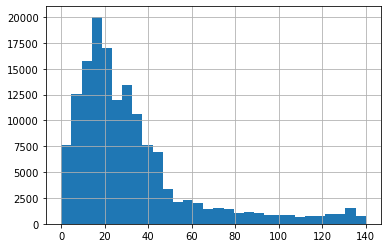

In [51]:
train_data['len_doc'] = train_data['document'].apply(lambda x: len(str(x)))
print(f"max length: {train_data['len_doc'].max()}")
print(f"min length: {train_data['len_doc'].min()}")
train_data['len_doc'].hist(bins=30)

In [52]:
check_sentence_with_length(train_data, 2)

최고
졸작
대박
버려
망함
굳굳
슬픔
안습
망작
쵝오
쵝오
최고
최고
별루
씐나
아오
글쎄
어휴
쓰렉
최고
짱짱


In [53]:
check_sentence_with_length(train_data, train_data.len_doc.max())

타짜는10점받아마땅하다 영화의모든부분이다재밌었다 캐릭터들은원작보다훨씬더매력적으로재현됐고 단역까지모든캐릭터가제몫을했다 긴이야기를아주 딱맞게압축했다 전국중고딩에게섯다열풍을몰고온 막판고니와아귀의설전을전국민이외우게만든작품 영화사에남을장면들이가득담겨있는선물세트
그래서 중국은 꿈을 펼치기에는 좋지않은 땅이라는 뜻이냐?그게 하루에100명가까이 15초마다 한건씩 살인이 일어나는 나라의국민이 할만한 주장이냐?유오성 닮은 츠차오의 발레공연장면만 볼만하다 어딘가 매카시즘의 반공유령이 떠다니고 있는듯한 기분이 드는 영화
티비에서 해준거보고 빡쳐서 들어와서 쓴다 주인공커플 하는일 하나두없음 쫓기며 돌아다니기만하고 싸움중인 군인 불러대면서 구해달라 난리치고 주인공답게 뭐 하는것없어 답답해 죽겠는데 쓸데없이 화면은 느리게잡고 마지막엔 아오뽁쳐 엔딩화면뜨는데 온가족이 말잃음
나는 나쁘지 않게 봤다만 대부분의사람들은 뭔가 있어보이면 명작이라고 칭송한단 말이지 니들이 이해못해서 재미없다고 하는 정신승리를 곁들여 말이야 연출은 참신했으나 복선이 진부하고 각 플롯마다 연관성이 부족했다 뭐 이것도 감독이 설계했다하면 할말 없겠지만
175분이 너무나 짧게 느껴졌다 명대사며 명언이며 연기며 캐릭터까지 잊을 수가 없는 영화 초반부터 교훈적이 말들이 나와 정말 중독되었다 원래 봤던 영화를 또 보면 지루하지만 이 영화는 끝까지 보게 하는 영화다 내가 느와르를 좋아하게 되는 계기 책도 짱
보다가 어처구니가 없어서 존쿠삭이나 애드리안브로디 를 삼류로 만드는 감독의 능력 일단 각본이 말이 안되는게 너무 많다 성룡이 어렸을때 자기 동생 우는걸 막다가 죽이고 또 그거에 분해서 장군을 칼로 찌른거 맞지? 사실 그냥 틀어놓고 자꾸 딴일을 하게돼서
이런컨셉이면 최소한 현실성에 기반을 두는데 이건 공상을 넘어선 허상 킬링탐용도 안됨 잠이안와서 뭔가 하나라도 스킵 해가면서 보려느 목적이라도 이건 보지마소 짜증나서 잠이 깰듯 내가 이거 호주에서 봤는데 이거 다 욕했음 밑엣놈은 그저 한국까는 한국쓰레기
부성애인지 맬로인지 거기

+ 이런건 내가 봐도 긍정인지 부정인지 모르겠다. 빵점 원주율 얘기 나오는거 보면 평점 낮추겠다는 얘기 같은데 그거 빼고 보면 도통 무슨 얘긴지 모르겠다. 

In [54]:
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

In [55]:
len(train_data), len(test_data)

(142958, 48258)

max length: 140
min length: 0


<AxesSubplot:>

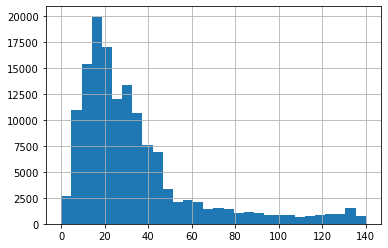

In [56]:
train_data['len_doc'] = train_data['document'].apply(lambda x: len(str(x)))
print(f"max length: {train_data['len_doc'].max()}")
print(f"min length: {train_data['len_doc'].min()}")
train_data['len_doc'].hist(bins=30)

In [57]:
cond = train_data['len_doc'] >= 2
len(train_data[cond]) / len(train_data) * 100

99.92795086668812

max length: 140
min length: 0


<AxesSubplot:>

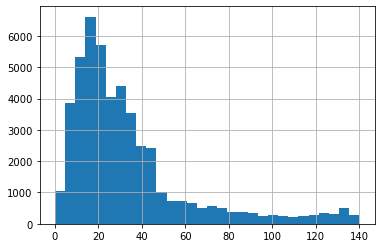

In [58]:
test_data['len_doc'] = test_data['document'].apply(lambda x: len(str(x)))
print(f"max length: {test_data['len_doc'].max()}")
print(f"min length: {test_data['len_doc'].min()}")
test_data['len_doc'].hist(bins=30)

In [59]:
cond = train_data['len_doc'] >= 2
len(train_data[cond]) / len(train_data) * 100

99.92795086668812

In [60]:
cond = train_data['len_doc'] == 2
train_data[cond]

,id,document,label,len_doc
56,1651126,최고,0,2
72,5679106,졸작,0,2
113,7115568,대박,1,2
185,1870395,버려,0,2
278,7124022,망함,0,2
...,...,...,...,...
146623,7994209,무미,0,2
146798,7876876,아잉,1,2
147572,4581116,됐고,0,2
148185,4157148,살색,0,2


In [61]:
# 길이 조건에 맞는 문장만 선택합니다.
import numpy as np

def filter_corpus(sentence, min_len):
    sentence = str(sentence)
    if len(sentence) >= min_len:
        sentence = sentence
    else:
        sentence = np.nan
        
    return sentence

# 2 미만 문서 삭제
min_len = 2

train_data['new_doc'] = train_data['document'].map(lambda x: filter_corpus(x, min_len))
test_data['new_doc'] = test_data['document'].map(lambda x: filter_corpus(x, min_len))

In [62]:
train_data.isna().sum()

id            0
document      0
label         0
len_doc       0
new_doc     103
dtype: int64

In [63]:
train_data.dropna(axis=0, inplace=True)
train_data.isna().sum()

id          0
document    0
label       0
len_doc     0
new_doc     0
dtype: int64

In [64]:
len(train_data)

142855

max length: 140
min length: 2


<AxesSubplot:>

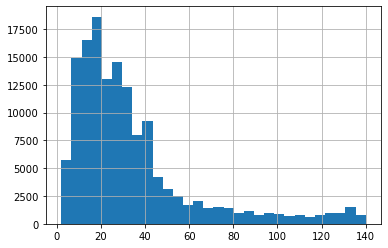

In [65]:
train_data['len_doc'] = train_data['new_doc'].apply(lambda x: len(str(x)))
print(f"max length: {train_data['len_doc'].max()}")
print(f"min length: {train_data['len_doc'].min()}")
train_data['len_doc'].hist(bins=30)

In [67]:
cond = train_data['len_doc'] == 2
train_data[cond]

,id,document,label,len_doc,new_doc
56,1651126,최고,0,2,최고
72,5679106,졸작,0,2,졸작
113,7115568,대박,1,2,대박
185,1870395,버려,0,2,버려
278,7124022,망함,0,2,망함
...,...,...,...,...,...
146623,7994209,무미,0,2,무미
146798,7876876,아잉,1,2,아잉
147572,4581116,됐고,0,2,됐고
148185,4157148,살색,0,2,살색


In [68]:
test_data.isna().sum()

id           0
document     0
label        0
len_doc      0
new_doc     65
dtype: int64

In [69]:
test_data.dropna(axis=0, inplace=True)
test_data.isna().sum()

id          0
document    0
label       0
len_doc     0
new_doc     0
dtype: int64

In [70]:
len(test_data)

48193

max length: 140
min length: 2


<AxesSubplot:>

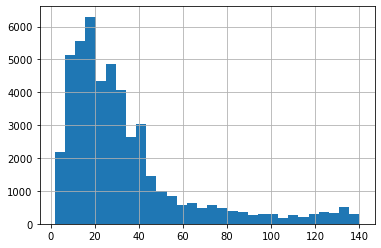

In [71]:
test_data['len_doc'] = test_data['document'].apply(lambda x: len(str(x)))
print(f"max length: {test_data['len_doc'].max()}")
print(f"min length: {test_data['len_doc'].min()}")
test_data['len_doc'].hist(bins=30)

In [73]:
cond = test_data['len_doc'] == 2
test_data[cond]

,id,document,label,len_doc,new_doc
16,2968565,최고,1,2,최고
60,9745015,콩콩,0,2,콩콩
174,6915908,어썸,1,2,어썸
219,1050028,글쎄,0,2,글쎄
243,115954,감동,1,2,감동
...,...,...,...,...,...
47803,7225811,아참,0,2,아참
48099,5536472,망덕,0,2,망덕
48576,7894255,뒷북,0,2,뒷북
48777,3015444,동감,0,2,동감


---
### spm

In [76]:
# sentence piece 사용

import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/naver_movie/review.train.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in train_data['new_doc']:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    "--input={} --model_type=bpe --model_prefix=spm_bpe --vocab_size={}".format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l spm_bpe*

-rw-rw-r-- 1 ssac7 ssac7 373671 Apr 20 17:14 spm_bpe.model
-rw-rw-r-- 1 ssac7 ssac7 118902 Apr 20 17:14 spm_bpe.vocab


In [77]:
s = spm.SentencePieceProcessor()
s.Load('spm_bpe.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[4505, 862, 6726, 6488, 1347, 6484, 6579, 6478, 0]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다 ⁇ 


In [78]:
# unigram 사용
vocab_size = 8000


spm.SentencePieceTrainer.Train(
    "--input={} --model_prefix=spm_unigram --vocab_size={}".format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l spm_unigram*

-rw-rw-r-- 1 ssac7 ssac7 378253 Apr 20 17:15 spm_unigram.model
-rw-rw-r-- 1 ssac7 ssac7 147757 Apr 20 17:15 spm_unigram.vocab


In [79]:
s = spm.SentencePieceProcessor()
s.Load('spm_unigram.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1211, 9, 389, 12, 1182, 9, 135, 13, 0]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다 ⁇ 


+ bpe는 아버지가를 아버, 지가로 나눈 반변 unigram은 아버지, 가 로 나누었다. unigram이 bpe보다 잘 나누는 것 같다.

In [82]:
import tensorflow as tf

def sp_tokenize(s, train_corpus, test_corpus):

    train_tensor = []
    test_tensor = []

    for sen in train_corpus:
        train_tensor.append(s.EncodeAsIds(sen))
        
    for sen in test_corpus:
        test_tensor.append(s.EncodeAsIds(sen))

    with open("./spm_unigram.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    return train_tensor, test_tensor, word_index, index_word

In [83]:
train_tensor, test_tensor, word_index, index_word = sp_tokenize(s, train_data['new_doc'], test_data['new_doc'])

In [84]:
len(train_tensor), len(test_tensor), len(word_index), len(index_word)

(142855, 48193, 8000, 8000)

In [85]:
train_tensor[0]

[49, 747, 25, 1864, 54, 1624]

Data Size: 142855
문장의 최단 길이: 1
문장의 최장 길이: 133
문장의 평균 길이: 15


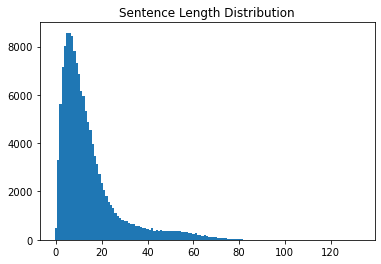

In [86]:
# 학습된 sp_tokenize로 나눈 문장 길이 분포 확인
import matplotlib.pyplot as plt

min_len = 999
max_len = 0
sum_len = 0

print("Data Size:", len(train_tensor))

for sen in train_tensor:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_tensor))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_tensor:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

Data Size: 48193
문장의 최단 길이: 1
문장의 최장 길이: 112
문장의 평균 길이: 15


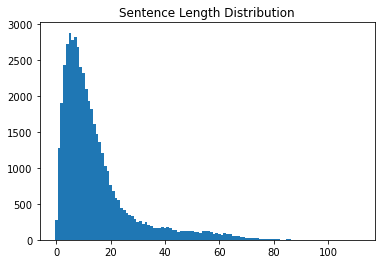

In [88]:
# 학습된 sp_tokenize로 나눈 문장 길이 분포 확인
import matplotlib.pyplot as plt

min_len = 999
max_len = 0
sum_len = 0

print("Data Size:", len(test_tensor))

for sen in test_tensor:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(test_tensor))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in test_tensor:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [100]:
# 문장 보기 
def decode_tensor(tensor, target_len):
    
    s = spm.SentencePieceProcessor()
    s.Load('spm_unigram.model')
    count = 0
    
    for c in tensor:
        if len(c) == target_len:
            print(s.DecodeIds(c))
            count += 1
            if count == 10 : return        

In [107]:
decode_tensor(train_tensor, 1)

재미있어요
최고
졸작
킬링타임
대박
별로다
좋은영화
굳굳
슬픔
안습


In [108]:
decode_tensor(train_tensor, 2)

전 좋아요
심심한영화
매우 실망
인상적인 영화였다
재미있는영화입니다
내용이 이상해
아 빵점
좋구나
볼만해
10점


In [109]:
decode_tensor(train_tensor, 30)

사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
정말 오월의 멜로는 정말로 보고보고 또봐도 계속 보고싶은 영화순위 1순위다하 늦은 밤이라 그런지 야릇한 느낌이 들었다
정말 질질끌고 작가님제발좀 적당히하시죠은희수역맡은 사람도 그만 나쁘게 만들지아침드라마가 막장이네
자꾸 뭘 설득할려하고 설교할려고하는게 보기거북하다 그리고결혼반지를 위해 범죄가담하다니 무슨 개역지설정이냐
살면서 처음 접해본 장르라서 조금 당황스럽다 솔직히 영화 자체는 100 자신의 색깔에 충실했고 완성도 역시 뛰어난 편이지만 좋아하지도 이해하지도 못하겠다
유럽영화가 이번정부에 많이 들어와 즐겁긴하다만 그 내용들이 왜 이리 진부한걸까 유럽영화를 욕되게 하고있단 소리다
미성년자가 돈많은 아저씨에게 순결을 바치고 데인후 결국 정신차리고 공부해거 명문대가는 진부한 결말
올밴 재편성때 광희한테 쫓겨나고 이번엔 유세윤 음주운전때매 쫓겨나고 안타깝고 실망스러울뿐이다
당시 명필름을 부도직전까지 몰고갔던 문제적졸작 한동안이은 심재명부부는넉다운당함
아이유가 나오는데 시청률이 4점대라니 한채영 아이유만가가지고도 어느정도는 나올텐데 문제는 장근석이야 남자는물론 여자들도 싫어하니


In [101]:
decode_tensor(test_tensor, 1)

최고
감동적이다
볼만함
귀여워
글쎄
감동
볼만하다
재미있어요
좋아요
별로다


In [102]:
decode_tensor(test_tensor, 2)

진정한 쓰레기
나이스
너무너무 재밌다
콩콩
괜찮아요
너무 좋았음
어썸
다시보고싶다
재미가 없다
재미있는데여


In [104]:
decode_tensor(test_tensor, 30)

작가의 예리함과 필력에 박수를 보냅니다 진보한 드라마란 바로 이런 것 시청률 의식하지마시고 앞으로도 좋은내용 부탁드립니다
어릴때 감동적으로 본 영화라 잊지 못합니다 라스트장면에서 이불 뒤집어쓰고 울었던 기억이 꼭 다시 보고 싶습니다 파일 좀 보내주세요
30대 여자의 노처녀 히스테리에 열등감이 더해지면 어떻게 되는지를 보여주는 영화 골때리고 끝내주게 웃겨준다
좋네요 저 밑에 우리나라 사형제도 폐지 됐다고 하는데폐지된거 아닙니다 다만 형의 집행을 계속 시행하지 않고 있을뿐
액션 만화일까 싶어서 봤는데 처음부터 끝까지 일관된 개소리로 와닿지 않는 개똥철학만 구구절절이  ⁇ 어댐
지킬박사 늑대인간 뱀파이어 프랑켄슈타인의 괴물까지 세계문학을 읽는 기분 그리고 스토리와 액션도 사랑도 모두 최고였음
아직 더럽혀지지 않은 새하얀 눈 그 위엔 대원들의 보이지 않는 여러 감정들이 뒤섞여 더럽혀지고 있다
잊혀질만 하면 또 보고싶은 영화 20살때 이영화를 알았는데 그뒤로 1년에 한두번씩은 보는것 같다 마음이 아프면서도 따듯해지는 영화다
처음으로 핸드폰에 외국영화넣고 엠피쓰리처럼 듣고다녔다 이영화가없었다면 지금난 모하고있었을까
개인적으로 정말 감동이 깊었던 영화임 도 다좋고 주인공들 미래모습볼수 있어서 좋았고타미코하고 짱구 둘의 사랑모습이 너무감동적이었음


+ 토큰 길이가 1개여도 문제가 없을까? 
  + 해당 표현에 대한 강한 편향을 만들지 않을까?
  + 알 수 없으므로 제거하지 않고 일단 진행해 보기로 한다.
+ 리뷰의 긍정 부정을 판단하는 비교적 간단한 문제이고 토큰이 30개 정도 되는 리뷰의 경우 충분한 단어가 들어가 있다.
  + 분포 상으로도 30개 미만에 주된 리뷰가 몰려 있으므로 30개를 넘는 리뷰 전체를 데이터로 넣을 필요는 없을 것 같다.

In [110]:
maxlen = 30
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_tensor, padding='post', maxlen = maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_tensor, padding='post', maxlen = maxlen)

In [111]:
y_train = np.array(list(train_data['label']))
y_test =  np.array(list(test_data['label']))

In [112]:
len(X_train), len(y_train)

(142855, 142855)

In [113]:
len(X_test), len(y_test)

(48193, 48193)

In [117]:
# 모델 작성
from tensorflow import keras

embedding_size = 10
hidden_size = 10


model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_size),# (Size of the vocabulary, Dimension of the dense embedding)
    keras.layers.LSTM(hidden_size),
    keras.layers.Dense(hidden_size, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          80000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 80,961
Trainable params: 80,961
Non-trainable params: 0
_________________________________________________________________


In [114]:
# 체크포인트
checkpoint_dir = os.getenv('HOME')+'/aiffel/sp_tokenizer/naver_movie/models/sp_unigram'

checkpoint_dir

'/home/ssac7/aiffel/sp_tokenizer/naver_movie/models/sp_unigram'

In [118]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_acc',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              mode='auto',
                                              verbose=1,
                                              patience=3)

In [119]:
# model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [121]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    callbacks=[early_stop, cp_callback], 
                    batch_size=128 ,
                    validation_split=0.2)

Epoch 1/20
880/893 [============================>.] - ETA: 0s - loss: 0.4553 - acc: 0.7690
Epoch 00001: val_acc improved from -inf to 0.84243, saving model to /home/ssac7/aiffel/sp_tokenizer/naver_movie/models/sp_unigram
893/893 [==============================] - 4s 4ms/step - loss: 0.4540 - acc: 0.7699 - val_loss: 0.3603 - val_acc: 0.8424
Epoch 2/20
880/893 [============================>.] - ETA: 0s - loss: 0.3394 - acc: 0.8526
Epoch 00002: val_acc improved from 0.84243 to 0.84589, saving model to /home/ssac7/aiffel/sp_tokenizer/naver_movie/models/sp_unigram
893/893 [==============================] - 4s 4ms/step - loss: 0.3398 - acc: 0.8524 - val_loss: 0.3534 - val_acc: 0.8459
Epoch 3/20
888/893 [============================>.] - ETA: 0s - loss: 0.3229 - acc: 0.8603
Epoch 00003: val_acc did not improve from 0.84589
893/893 [==============================] - 4s 4ms/step - loss: 0.3231 - acc: 0.8602 - val_loss: 0.3498 - val_acc: 0.8451
Epoch 4/20
886/893 [============================>.]

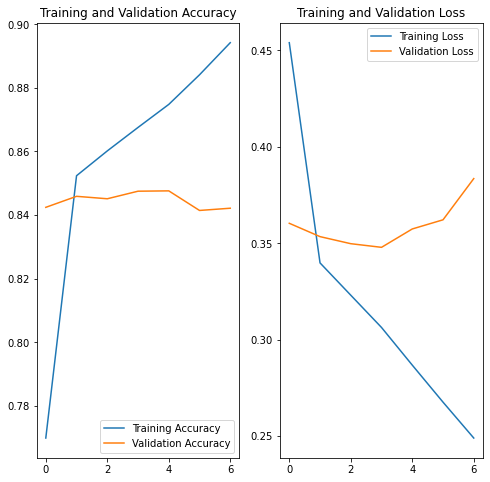

In [124]:
# trainig porgress plot
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [125]:
model.load_weights(checkpoint_dir)

In [126]:
model.evaluate(X_test, y_test)

1507/1507 [==============================] - 3s 2ms/step - loss: 0.3667 - acc: 0.8436


[0.3666558265686035, 0.8436287641525269]

---


# mecab 토큰화

In [177]:
from konlpy.tag import Mecab

mecab = Mecab()

In [178]:
# 형태소 기반 토큰화
def mecab_split(sentence):
    
    return mecab.morphs(sentence)

mecab_train = []

for sentence in train_data['new_doc']:
    mecab_train.append(mecab_split(sentence))

mecab_test = []

for sentence in test_data['new_doc']:
    mecab_test.append(mecab_split(sentence))
    

In [179]:
from collections import Counter

words = np.concatenate(mecab_train).tolist()
counter = Counter(words)
counter = counter.most_common(vocab_size)
vocab = ['<UNK>'] + [key for key, _ in counter] 
word_to_index = {word:index for index, word in enumerate(vocab)} 

In [180]:
len(counter)

8000

In [181]:
len(vocab)

8001

In [182]:
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

train_tensor = list(map(wordlist_to_indexlist, mecab_train))
test_tensor = list(map(wordlist_to_indexlist, mecab_test))

len(train_tensor), len(test_tensor)

(142855, 48193)

In [183]:
maxlen = 30
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_tensor, padding='post', maxlen = maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_tensor, padding='post', maxlen = maxlen)

In [189]:
# 모델 작성

embedding_size = 10
hidden_size = 10


model = keras.Sequential([
    keras.layers.Embedding(vocab_size+1, embedding_size),# (Size of the vocabulary, Dimension of the dense embedding)
    keras.layers.LSTM(hidden_size),
    keras.layers.Dense(hidden_size, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 10)          80010     
_________________________________________________________________
lstm_7 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_14 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 80,971
Trainable params: 80,971
Non-trainable params: 0
_________________________________________________________________


In [190]:
# 체크포인트
checkpoint_dir = os.getenv('HOME')+'/aiffel/sp_tokenizer/naver_movie/models/alt_mecab'

checkpoint_dir

'/home/ssac7/aiffel/sp_tokenizer/naver_movie/models/alt_mecab'

In [191]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_acc',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              mode='auto',
                                              verbose=1,
                                              patience=3)

In [192]:
# model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [193]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    callbacks=[early_stop, cp_callback], 
                    batch_size=128 ,
                    validation_split=0.2)

Epoch 1/20
884/893 [============================>.] - ETA: 0s - loss: 0.4476 - acc: 0.7843
Epoch 00001: val_acc improved from -inf to 0.84075, saving model to /home/ssac7/aiffel/sp_tokenizer/naver_movie/models/alt_mecab
893/893 [==============================] - 4s 4ms/step - loss: 0.4468 - acc: 0.7847 - val_loss: 0.3652 - val_acc: 0.8407
Epoch 2/20
888/893 [============================>.] - ETA: 0s - loss: 0.3444 - acc: 0.8505
Epoch 00002: val_acc improved from 0.84075 to 0.84110, saving model to /home/ssac7/aiffel/sp_tokenizer/naver_movie/models/alt_mecab
893/893 [==============================] - 4s 4ms/step - loss: 0.3442 - acc: 0.8506 - val_loss: 0.3643 - val_acc: 0.8411
Epoch 3/20
882/893 [============================>.] - ETA: 0s - loss: 0.3253 - acc: 0.8591
Epoch 00003: val_acc improved from 0.84110 to 0.84173, saving model to /home/ssac7/aiffel/sp_tokenizer/naver_movie/models/alt_mecab
893/893 [==============================] - 4s 4ms/step - loss: 0.3257 - acc: 0.8589 - val_lo

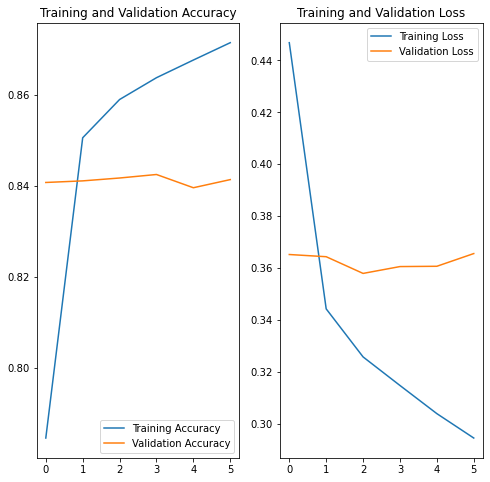

In [194]:
# trainig porgress plot
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [195]:
model.load_weights(checkpoint_dir)

In [196]:
model.evaluate(X_test, y_test)

1507/1507 [==============================] - 3s 2ms/step - loss: 0.3636 - acc: 0.8402


[0.36364883184432983, 0.84016352891922]

+ sentence piece 로 토큰화 한 데이터의 test accuracy가 더 높다.